In [1]:
%load_ext autoreload
%autoreload 2
%load_ext lab_black

import matplotlib.pyplot as plt
import numpy as np
import json
import pandas as pd
import seaborn as sns
import os
import admix
from os.path import join
import itertools
import admix_genet_cor
import submitit
import glob
from scipy.stats import pearsonr, linregress
from tqdm import tqdm
import string
import pickle
import admix
import dapgen
import matplotlib

matplotlib.rcParams["font.family"] = ["Liberation Sans"]

In [2]:
# define the simulation parameters
df_real_params = pd.DataFrame(
    [
        params
        for params in itertools.product(
            ["real"],
            [f"region{i}" for i in np.arange(100)],
            [0.006],
            [1, 41],
        )
    ],
    columns=["group", "region", "hsq", "ncausal"],
)

df_simu_params = pd.DataFrame(
    [
        params
        for params in itertools.product(
            ["simu"],
            [f"region{i}.eur20.afr80" for i in np.arange(100)]
            + [f"region{i}.eur80.afr20" for i in np.arange(100)],
            [0.006],
            [1, 41],
        )
    ],
    columns=["group", "region", "hsq", "ncausal"],
)
df_params = pd.concat([df_real_params, df_simu_params])
df_params["config"] = df_params.apply(
    lambda row: f"group-{row.group}-region-{row.region}-hsq-{row.hsq}-ncausal-{int(row.ncausal)}",
    axis=1,
)

In [3]:
result_file = "results/dict_df_res_real+simu.pkl"
if os.path.exists(result_file):
    with open(result_file, "rb") as f:
        dict_df_res = pickle.load(f)
else:
    dict_df_res = {}

    for group in ["causal", "clump"]:
        df_res = []
        for param_i, param in tqdm(df_params.iterrows(), total=len(df_params)):
            for sim_i in range(50):
                path = f"out/covar-none/summary/{param.config}/sim_{sim_i}.{group}.tsv"
                if os.path.exists(path):
                    df_tmp = pd.read_csv(path, sep="\t")
                    df_tmp["group"] = param.group
                    df_tmp["region"] = param.region
                    df_tmp["ncausal"] = param.ncausal
                    df_tmp["hsq"] = param.hsq
                    df_tmp["sim_i"] = sim_i
                    df_res.append(df_tmp)

        df_res = pd.concat(df_res).reset_index(drop=True)
        # filter for SNPs with super small MAF in either one of the populations
        df_res = df_res[(df_res.se1 > 1e-6) & (df_res.se2 > 1e-6)]
        print(group, np.mean(df_res.het_pval < 0.05))
        df_res.loc[df_res.region.str.endswith("eur20.afr80"), "group"] = "simu1"
        df_res.loc[df_res.region.str.endswith("eur80.afr20"), "group"] = "simu2"
        dict_df_res[group] = df_res

    with open(result_file, "wb") as f:
        pickle.dump(dict_df_res, f)

In [4]:
def summarize_res(df_res_grouped):
    # 1st local ancestry = AFR, 2nd local ancestry = EUR
    df_plot = pd.DataFrame(
        {
            "het_inflation": df_res_grouped.apply(
                lambda x: admix.data.lambda_gc(x["het_pval"])
            ),  # HET p-value
            "het_fpr": df_res_grouped.apply(lambda x: np.mean(x["het_pval"] < 0.05)),
            "pearsonr": df_res_grouped.apply(
                lambda x: pearsonr(x["coef1"], x["coef2"])[0]
            ),  # Pearson's correlation between two coefficents
            "deming_afr~eur": df_res_grouped.apply(
                lambda x: admix_genet_cor.locus.deming_regression(
                    x=x["coef1"], y=x["coef2"], sx=x["se1"], sy=x["se2"]
                )[0]
            ),  # EUR ~ AFR
            "deming_eur~afr": df_res_grouped.apply(
                lambda x: admix_genet_cor.locus.deming_regression(
                    x=x["coef2"], y=x["coef1"], sx=x["se2"], sy=x["se1"]
                )[0]
            ),  # AFR ~ EUR
            "ols_afr~eur": df_res_grouped.apply(
                lambda x: linregress(x=x["coef1"], y=x["coef2"])[0]
            ),
            "ols_eur~afr": df_res_grouped.apply(
                lambda x: linregress(x=x["coef2"], y=x["coef1"])[0]
            ),
        }
    )

    df_plot = df_plot.reset_index(drop=False)
    return df_plot

In [5]:
n_bootstrap = 100
sample_size = 500

np.random.seed(1234)

dict_df_plot = {}

for group in ["causal", "clump"]:
    df_plot = []
    for i in tqdm(range(n_bootstrap)):
        df_plot.append(
            summarize_res(
                dict_df_res[group]
                .groupby(
                    [
                        "group",
                        "ncausal",
                        "hsq",
                    ]
                )
                .sample(n=sample_size)
                .groupby(
                    [
                        "group",
                        "ncausal",
                        "hsq",
                    ]
                )
            ).set_index(
                [
                    "group",
                    "ncausal",
                    "hsq",
                ]
            )
        )
    df_plot_mean = pd.DataFrame(
        np.mean(df_plot, axis=0), index=df_plot[0].index, columns=df_plot[0].columns
    ).reset_index()
    df_plot_se = pd.DataFrame(
        np.std(df_plot, axis=0), index=df_plot[0].index, columns=df_plot[0].columns
    ).reset_index()
    dict_df_plot[group] = (df_plot_mean, df_plot_se)

100%|██████████| 100/100 [03:11<00:00,  1.91s/it]


In [7]:
dict_group_name = {
    "causal": "Causal",
    "clump": "Clumped",
}
dict_column_name = {
    "het_fpr": "HET FPR",
    "deming_afr~eur": "Deming (AFR$\sim$EUR)",
    "deming_eur~afr": "Deming (EUR$\sim$AFR)",
    "pearsonr": "Pearson r",
    "ols_afr~eur": "OLS (AFR$\sim$EUR)",
    "ols_eur~afr": "OLS (EUR$\sim$AFR)",
}

In [8]:
df_display = []
for group in ["causal", "clump"]:
    df_plot_mean, df_plot_se = dict_df_plot[group]
    df_tmp = (
        df_plot_mean.set_index(["group", "ncausal"]).round(3).astype(str)
        + " ("
        + df_plot_se.set_index(["group", "ncausal"]).round(3).astype(str)
        + ")"
    )
    df_tmp.index = df_tmp.index.set_levels(
        ["PAGE", "Simu 20\% EUR 80\% AFR", "Simu 80\% EUR 20\% AFR"], level=0
    )

    df_tmp.index.names = ["group", "$n_\\text{causal}$"]
    df_tmp = df_tmp[dict_column_name.keys()]
    df_tmp.rename(columns=dict_column_name, inplace=True)
    print(df_tmp.to_latex(escape=False))

\begin{tabular}{llllllll}
\toprule
                       &    &        HET FPR & Deming (AFR$\sim$EUR) & Deming (EUR$\sim$AFR) &      Pearson r & OLS (AFR$\sim$EUR) & OLS (EUR$\sim$AFR) \\
group & $n_\text{causal}$ &                &                       &                       &                &                    &                    \\
\midrule
PAGE & 1  &   0.052 (0.01) &         0.999 (0.008) &         1.001 (0.008) &  0.964 (0.004) &      0.947 (0.016) &      0.981 (0.016) \\
                       & 41 &  0.623 (0.023) &         0.888 (0.047) &          1.129 (0.06) &  0.748 (0.019) &      0.651 (0.023) &       0.86 (0.035) \\
Simu 20\% EUR 80\% AFR & 1  &  0.048 (0.008) &         0.995 (0.008) &         1.005 (0.008) &  0.968 (0.004) &      0.946 (0.018) &       0.99 (0.017) \\
                       & 41 &    0.6 (0.021) &         0.922 (0.038) &         1.086 (0.045) &  0.808 (0.014) &      0.727 (0.022) &      0.899 (0.028) \\
Simu 80\% EUR 20\% AFR & 1  &  0.047 (0.008) &

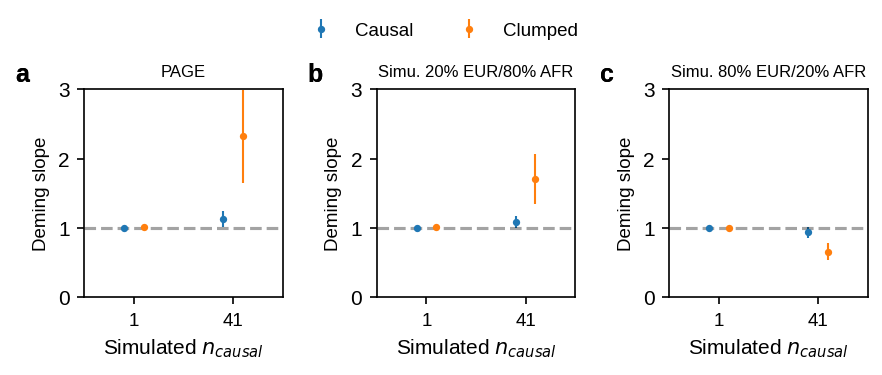

In [11]:
fig, axes = plt.subplots(figsize=(6, 2.3), ncols=3, nrows=1, dpi=150)

# for causal SNPs and clumped SNPs
for group_i, group in enumerate(["causal", "clump"]):
    df_mean, df_se = dict_df_plot[group]

    # for each panel
    for i, dset in enumerate(["real", "simu1", "simu2"]):
        ax = axes[i]
        dset_mean = df_mean[df_mean.group == dset]
        dset_se = df_se[df_se.group == dset]

        if i == 0:
            label = {
                "causal": "Causal",
                "clump": "Clumped",
            }[group]
        else:
            label = None

        ax.errorbar(
            np.arange(len(dset_mean.ncausal)) - 0.1 + 0.2 * group_i,
            dset_mean["deming_eur~afr"],
            yerr=dset_se["deming_eur~afr"] * 1.96,
            fmt=".",
            ms=5,
            linewidth=1,
            mew=1,
            label=label,
        )

        ax.set_xticks([0, 1])
        ax.set_xticklabels([1, 41], fontsize=9)
        ax.axhline(y=1.0, color="black", ls="--", alpha=0.2)

        ax.set_ylabel("Deming slope", fontsize=9)

        ax.set_xlabel("Simulated $n_{causal}$")
        # annotation
        ax.text(
            -0.35,
            1.04,
            string.ascii_lowercase[i],
            transform=ax.transAxes,
            size=12,
            weight="bold",
        )
        ax.set_xlim(-0.5, 1.5)
        ax.set_ylim(0, 3)
        ax.set_title(
            {
                "real": "PAGE",
                "simu1": "Simu. 20% EUR/80% AFR",
                "simu2": "Simu. 80% EUR/20% AFR",
            }[dset],
            fontsize=8,
        )


handles, labels = axes[0].get_legend_handles_labels()
fig.legend(
    handles,
    labels,
    ncol=6,
    loc="center",
    bbox_to_anchor=[0.5, 1.02],
    frameon=False,
    fontsize=9,
)
fig.tight_layout()
plt.savefig("results/locus-simulation-vary-anc-prop.pdf", bbox_inches="tight")